In [7]:
import numpy as np
import pandas as pd
import shapefile as shp
from plotnine import *
import random

%matplotlib inline

In [72]:
def read_shapefile(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    df = pd.DataFrame(columns=fields, data=records)
    return df

def remove_last_word(content):
    return ' '.join(content.split(' ')[:-1])

In [5]:
# Read the file
file_path = "./trends.shp"
sf = shp.Reader(file_path)
df = read_shapefile(sf)
df.head()

,id,county,trend,p,z,slope,intercept
0,6037500403,Los Angeles County,no trend,0.152406,-1.431084,-66.375000,4575.187500
1,6065045103,Riverside County,decreasing,0.015322,-2.424672,-94.428571,4157.928571
2,6065046404,Riverside County,increasing,0.002358,3.041052,311.000000,4748.000000
3,6065045108,Riverside County,increasing,0.004208,2.862167,212.875000,5267.062500
4,6037122122,Los Angeles County,increasing,0.001282,3.219938,84.888889,1935.000000


In [92]:
# Initialize county df
county_list = df["county"].unique()
county_df = pd.DataFrame({"county": [ remove_last_word(county) for county in county_list ],
                          "increasing": np.zeros(len(county_list)),
                          "decreasing": np.zeros(len(county_list)),
                          "no trend": np.zeros(len(county_list))})
for index, row in df.iterrows():
    trend = row["trend"]
    county = remove_last_word(row["county"])
    county_df.loc[county_df["county"] == county, trend] += 1
    
totals = { remove_last_word(county): len(df[df["county"] == county]) for county in county_list }
county_df.head()

,county,increasing,decreasing,no trend
0,Los Angeles,153.0,76.0,305.0
1,Riverside,165.0,30.0,160.0
2,Santa Clara,57.0,10.0,71.0
3,Orange,52.0,21.0,82.0
4,San Diego,114.0,16.0,149.0


In [85]:
blue = "#4A86CF"
red = "#ED6964"

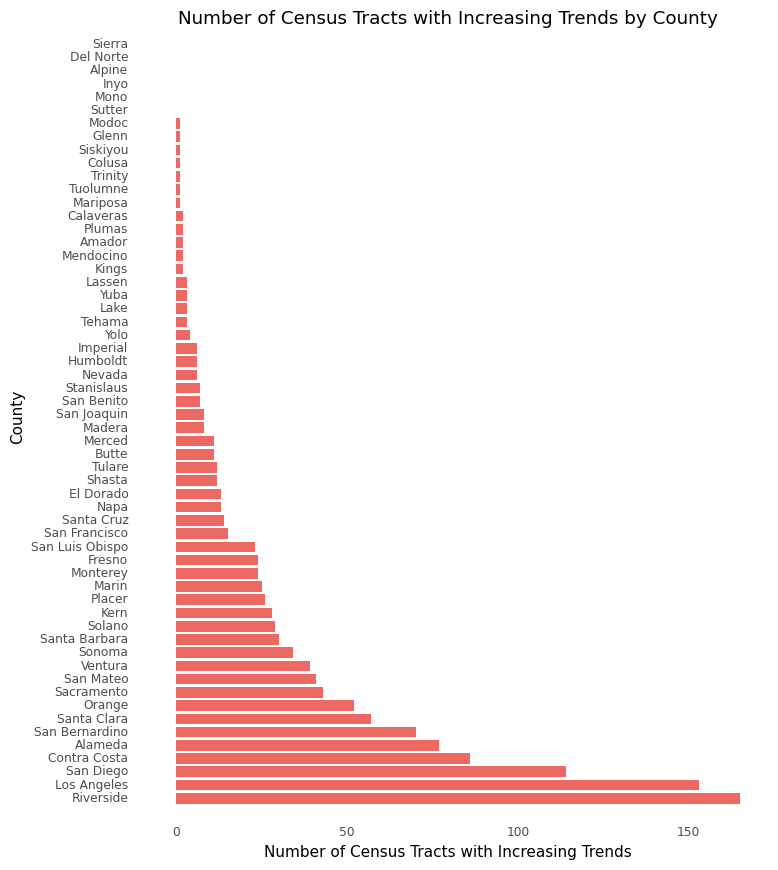

<ggplot: (124288818884)>

In [86]:
ggplot(county_df, aes("reorder(county, -increasing)", "increasing")) + \
    geom_bar(stat="identity", fill=red, width = 0.8) + \
    theme_minimal() + \
    theme(figure_size=(8, 10), panel_grid = element_blank()) + \
    coord_flip() + \
    labs(x="County", y="Number of Census Tracts with Increasing Trends", title="Number of Census Tracts with Increasing Trends by County")

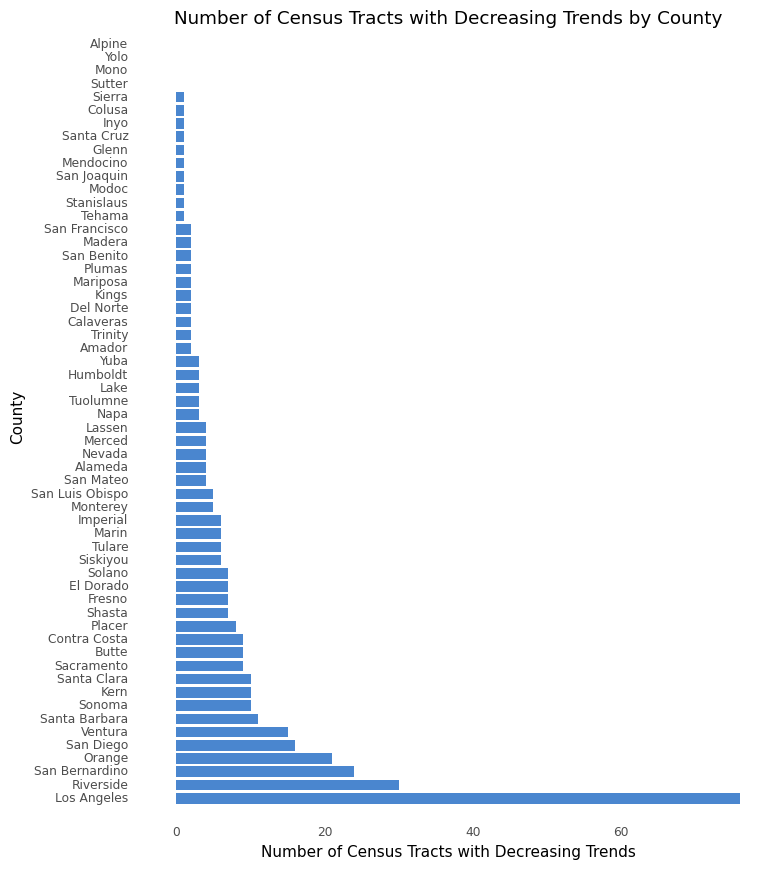

<ggplot: (124289007797)>

In [87]:
ggplot(county_df, aes("reorder(county, -decreasing)", "decreasing")) + \
    geom_bar(stat="identity", fill=blue, width = 0.8) + \
    theme_minimal() + \
    theme(figure_size=(8, 10), panel_grid = element_blank()) + \
    coord_flip() + \
    labs(x="County", y="Number of Census Tracts with Decreasing Trends", title="Number of Census Tracts with Decreasing Trends by County")

In [140]:
tidy = pd.melt(county_df, id_vars=['county'], var_name='trends')

def normalize(row):
    row["value"] = row["value"] / totals[row["county"]]
    return row

tidy = tidy.apply(normalize, axis=1)
tidy["trends"] = pd.Categorical(tidy["trends"], categories=["decreasing", "no trend", "increasing"], ordered=True)

# To be honest I kinda blanked here and woke up and the code was written
for index, row in tidy.iterrows():
    sort_value = tidy[(tidy["county"] == row["county"]) & (tidy["trends"] == "increasing")].iloc[0].value
    if sort_value <= 0:
        sort_value = -tidy[(tidy["county"] == row["county"]) & (tidy["trends"] == "decreasing")].iloc[0].value
    tidy.loc[index, "sort_value"] =  sort_value
        

tidy.head()

,county,trends,value,sort_value
0,Los Angeles,increasing,0.286517,0.286517
1,Riverside,increasing,0.464789,0.464789
2,Santa Clara,increasing,0.413043,0.413043
3,Orange,increasing,0.335484,0.335484
4,San Diego,increasing,0.408602,0.408602


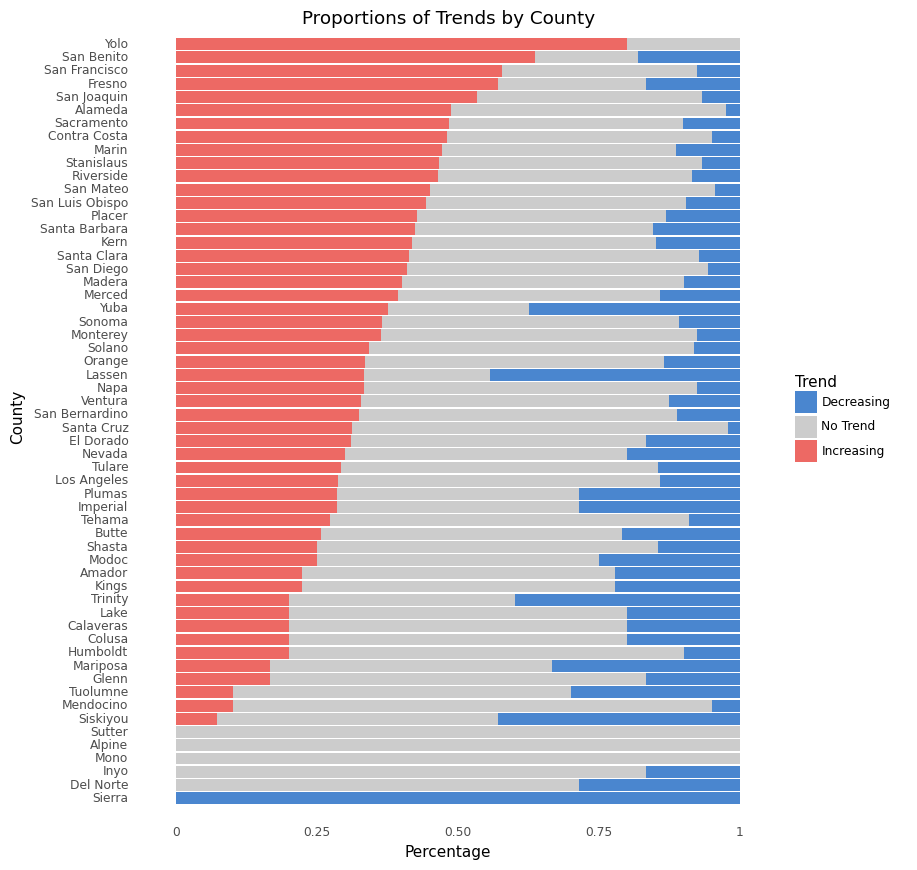

<ggplot: (124418210693)>

In [143]:
ggplot(tidy, aes('reorder(county, sort_value)', 'value', fill='trends')) + \
    geom_col() + \
    theme_minimal() + \
    scale_fill_manual(values=[blue, "#cccccc", red], name="Trend", labels=["Decreasing", "No Trend", "Increasing"]) + \
    theme(figure_size=(8, 10), panel_grid = element_blank()) + \
    coord_flip() + \
    labs(x="County", y="Percentage", title="Proportions of Trends by County")